<a href="https://colab.research.google.com/github/shlomi1993/deep-learning-notebooks/blob/main/5_splitlinear_dropnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5 - SplitLinear and DropNorm

## Introduction

In this notebook, we implement and avaluate two custom neural network layers in PyTorch.

In the first section, we implement **SplitLinear**, a layer that splits the input tensor, applies a shared linear transformation and ReLU activation to each half, and then concatenates the outputs to produce a tensor with the same shape as the input.

The second section focuses on the creation of **DropNorm**, a layer that combines Dropout and normalization in a single module. This question requires implementing the forward pass for both training and inference modes, properly initializing the layer's parameters, and comparing its performance with built-in PyTorch layers for Dropout and normalization.

### Global Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from torch import Tensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from typing import Tuple

## **SplitLinear**

In this section, we implement a custom PyTorch layer called `SplitLinear`. The layer gets an input tensor of shape $N \times M$, where $N$ is the batch size and $M$ is an even number of input features. The layer splits the input tensor evenly along the feature dimension ($M$), processes each half using the same linear transformation followed by a ReLU activation, and then concatenates the two outputs to produce a final tensor with the same shape as the input. Additionally, the implementation requires explicit initialization of the layer's parameters.

### SplitLinear Class Definition

In [ ]:
class SplitLinear(nn.Module):
    """
    A custom PyTorch layer that splits the input tensor along the feature dimension into two equal parts, applies the
    same Linear transformation and ReLU activation to both halves, and concatenates the results to form the output.

    Attributes:
        linear (nn.Linear): Linear transformation applied to each half.
        relu (nn.ReLU): ReLU activation function.
    """

    def __init__(self, input_dim: int, log_forward_steps: bool = False) -> None:
        """
        Initializes the SplitLinear layer.

        Args:
            input_dim (int): The number of input features (must be even).
            log_forward_steps (bool): Whether to log detailed steps during the forward pass. Defaults to False.

        Raises:
            AssertionError: If input_dim is not an even number.
        """
        super(SplitLinear, self).__init__()

        assert input_dim % 2 == 0, "input_dim must be even"
        half_dim = input_dim // 2

        # Same linear layer will be used for both halves
        self.linear = nn.Linear(half_dim, half_dim)

        # Initialize weights with a uniform distribution
        start = -(1 / torch.sqrt(torch.tensor(half_dim, dtype=torch.float)))
        end = 1 / torch.sqrt(torch.tensor(half_dim, dtype=torch.float))
        torch.nn.init.uniform_(self.linear.weight, start, end)

        # Use ReLU activation layer
        self.relu = nn.ReLU()

        # If set to True, logs detailed steps during the forward pass
        self.log_forward_steps = log_forward_steps


    def forward(self, x: Tensor) -> Tensor:
        """
        Defines the forward pass of the SplitLinear layer.

        Args:
            x (Tensor): Input tensor of shape (N, M), where N is the batch size and M is an even number of features.

        Returns:
            Tensor: Output tensor of shape (N, M), same as input shape.
        """
        if self.log_forward_steps:
            print(f"Step 1: The input tensor x is of shape:\n  x: {tuple(x.shape)}\n")

        x1, x2 = x[:, :self.linear.in_features], x[:, self.linear.in_features:]
        if self.log_forward_steps:
            print(f"Step 2: The input was split into two halves with shapes:\n  x1: {tuple(x1.shape)}\n  x2: {tuple(x2.shape)}\n")

        y1 = self.linear(x1)
        y2 = self.linear(x2)
        if self.log_forward_steps:
            print(f"Step 3: After applying the linear transformation:\n  y1: {tuple(y1.shape)}\n  y2: {tuple(y2.shape)}\n")

        a1 = self.relu(y1)
        a2 = self.relu(y2)
        if self.log_forward_steps:
            print(f"Step 4: After applying ReLU activation:\n  a1: {tuple(a1.shape)}\n  a2: {tuple(a2.shape)}\n")

        Y = torch.cat((a1, a2), dim=1)
        if self.log_forward_steps:
            print(f"Step 5: After concatenating the activated halves:\n  Y: {tuple(Y.shape)}\n")

        return Y

#### Forward Function

In the forward method, the input tensor is assumed to be of shape $(N, M)$, where $N$ is the batch size and $M$ is the number of features (Section 1).

The tensor is then split into two equal halves along the feature dimension $M$, assuming $M$ is even, resulting in two tensors of shape $(N, M/2)$ (Section 2).

Both halves of the split tensor are then passed through the same `nn.Linear` layer, followed by the ReLU activation, which satisfies the requirement of processing both halves through identical linear transformations and ReLU activations (Section 3).

Finally, the outputs of the two halves, `a1` and `a2`, are concatenated along the feature dimension using `torch.cat((a1, a2), dim=1)` (Section 4), which ensures that the final output tensor has the same dimensions as the input tensor $(N, M)$ (Section 5).

#### Initialization Function

The `__init__` method first validates that the input dimension is even so that the input tensor can be split into two equal halves.

A linear layer is created to perform the transformation on each half of the input tensor. The input and output dimensions of this linear layer are both set to `input_dim / 2`. This guarantees that both halves of the tensor will undergo the same linear transformation.

The weights of the linear layer are initialized using a uniform distribution over the following range:

$$ \left[ -\frac{1}{\sqrt{\frac{M}{2}}}, \frac{1}{\sqrt{\frac{M}{2}}} \right] $$

where $M$ is the number of input features. This initialization method helps mitigate issues such as vanishing or exploding gradients, which can hinder the training process by keeping the activations within a reasonable range during the early stages of training. This is a reasonable choice because the `nn.Linear` layer expects weights to be initialized in a way that prevents large activations, which could slow down convergence. Additionally, the use of a uniform distribution within this range is a simple yet effective approach to provide well-scaled initial weights. The biases are initialized by default to zeros, which is standard practice in most cases.

Note that the initialization avoids using the `reset_parameters` method, which is the built-in PyTorch method that reinitializes parameters using certain schemes.

A ReLU activation function is applied to the output of the linear transformation, introducing non-linearity into the model. This ensures that the model can learn non-linear relationships in the data.

### Instantiate a SplitLinear Layer

#### Instantiate the SplitLinear layer

Define batch size and even input dimension, which is the number of input features.

In [ ]:
batch_size = 4
input_dim = 8  # Even number to split

In [ ]:
splitlinear = SplitLinear(input_dim=input_dim, log_forward_steps=True)
splitlinear

SplitLinear(
  (linear): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
)

#### Create a sample input tensor (batch_size x input_dim)

In [ ]:
input_tensor = torch.ones(batch_size, input_dim)
input_tensor

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

#### Pass the input through the `SplitLinear` layer

In [ ]:
output_tensor = splitlinear(input_tensor)
output_tensor

Step 1: The input tensor x is of shape:
  x: (4, 8)

Step 2: The input was split into two halves with shapes:
  x1: (4, 4)
  x2: (4, 4)

Step 3: After applying the linear transformation:
  y1: (4, 4)
  y2: (4, 4)

Step 4: After applying ReLU activation:
  a1: (4, 4)
  a2: (4, 4)

Step 5: After concatenating the activated halves:
  Y: (4, 8)



tensor([[0.3261, 0.9040, 0.0000, 0.0000, 0.3261, 0.9040, 0.0000, 0.0000],
        [0.3261, 0.9040, 0.0000, 0.0000, 0.3261, 0.9040, 0.0000, 0.0000],
        [0.3261, 0.9040, 0.0000, 0.0000, 0.3261, 0.9040, 0.0000, 0.0000],
        [0.3261, 0.9040, 0.0000, 0.0000, 0.3261, 0.9040, 0.0000, 0.0000]],
       grad_fn=<CatBackward0>)

As we can see, the layer takes the input tensor, splits it into two equal parts, applies a linear transformation and ReLU activation to each part, and then concatenates the results to produce an output tensor with the same size as the input tensor.

Verify that `outout_tensor` is the returned `Y`

In [ ]:
output_tensor.shape

torch.Size([4, 8])

### SplitLinear Parameters

In the `SplitLinear` layer, the input tensor is divided along the feature dimension into two halves, each of shape $(N, \frac{M}{2})$, where $N$ is the batch size and $M$ is the input feature size. Both halves are processed by the same `nn.Linear` transformation, which has a weight matrix of shape $(\frac{M}{2}, \frac{M}{2})$ and a bias vector of shape $(\frac{M}{2})$.

Hence, the total number of parameters in the `SplitLinear` layer consists of $\frac{M}{2} \times \frac{M}{2}$ weights and $\frac{M}{2}$ bias terms:

$$
\text{#SplitLinearParameters} = \frac{M}{2} \times \frac{M}{2} + \frac{M}{2} = \frac{M^2}{4} + \frac{M}{2}
$$

In our example, $M=8$:

In [ ]:
input_dim

8

Therefore,

$$
\text{#SplitLinearParameters} =  \frac{M^2}{4} + \frac{M}{2} = \frac{8^2}{4} + \frac{8}{2} = 16 + 4 = 20
$$

We can verify this using the following line:

In [ ]:
splitlinear_param_count = sum(p.numel() for p in splitlinear.parameters() if p.requires_grad)
splitlinear_param_count

20

For a regular linear layer with input and output dimensions of $M$, the parameter count is straightforward. The weight matrix has a size of $M \times M$, and there are $M$ bias terms.

Hence, the total number of parameters in a standard `nn.Linear` layer is:

$$
\text{#LinearParameters} = M \times M + M = M^2 + M
$$



In out case:

$$
\text{#LinearParameters} = M^2 + M = 8^2 + 8 = 64 + 8 = 72
$$

We can verify this by creating an `nn.Linear` layer with the selected input and output dimensions and calculating the number of trainable parameters.

In [ ]:
linear = nn.Linear(input_dim, input_dim)
linear_param_count = sum(p.numel() for p in linear.parameters() if p.requires_grad)
linear_param_count



72

In conclusion, the `SplitLinear` layer reduces model complexity by using fewer parameters than a regular linear layer. It achieves this by reusing a smaller transformation on each half of the input, while still preserving the overall input-output shape.

### Cost Function Gradient

Given that the gradient of the loss function $C$ with respect to the output of a linear layer is:

$$
\frac{\partial C}{\partial y}
$$

we are asked to compute the gradients with respect to the parameters of the layer, which are the weight matrix
 $W$ and the bias vector $b$.

The linear layer computes:

$$
y = Wx + b
$$

where $x \in \mathbb{R}^{N \times 1}$ is the input, $W \in \mathbb{R}^{M \times N}$ is the weight matrix, $b \in \mathbb{R}^{M \times 1}$ is the bias, and $y \in \mathbb{R}^{M \times 1}$ is the output.

Since the bias is added elementwise to the output, the gradient with respect to the bias is simply:

$$
\frac{\partial C}{\partial b} = \frac{\partial C}{\partial y} \in \mathbb{R}^{M \times 1}
$$

For the weight matrix, we apply the chain rule. For each element $W_{ij}$, we get:

$$
\frac{\partial C}{\partial W_{ij}} = \frac{\partial C}{\partial y_i} \cdot x_j \in \mathbb{R}
$$

In matrix form, the full gradient is:

$$
\frac{\partial C}{\partial W} = \frac{\partial C}{\partial y} \cdot x^\top \in \mathbb{R}^{M \times N}
$$

where $\frac{\partial C}{\partial y}$ is treated as a column vector of shape $(M \times 1)$ and $x^\top$ is a row vector of shape $(1 \times N)$, resulting in a gradient matrix of shape $(M \times N)$.

### Cost Function Gradient in 4-Partition Case

If we were to split the input into four equal parts instead of two, and still apply the same linear transformation to each part using shared parameters, we would have fewer parameters, and the structure of the gradient would remain similar, but with four contributions instead of two.

Specifically, assume the input dimension is $M$, and we now split each input vector $x \in \mathbb{R}^{N \times M}$ into four equal parts, each of size $M/4$. For each part, we apply the same linear transformation using shared parameters:

- A weight matrix

$$
W \in \mathbb{R}^{(M/4) \times (M/4)}
$$

- A bias vector

$$
b \in \mathbb{R}^{M/4}
$$

Note that the number of shared parameters decreases compared to the 2-split version, but now these parameters are shared across more parts of the input.

Since the transformation is applied four times independently with shared weights, and the outputs are then concatenated, the total gradient of the loss $C$ with respect to the shared weights and bias will be the sum of the gradients from all four parts.

That is, if $\frac{\partial C}{\partial y^{(i)}}$ is the gradient of the loss with respect to the output of part $i$, then the gradient with respect to the weights is:
$$
\frac{\partial C}{\partial W} = \sum_{i=1}^{4} \frac{\partial C}{\partial y^{(i)}} \cdot (x^{(i)})^\top
$$

and similarly:

$$
\frac{\partial C}{\partial b} = \sum_{i=1}^{4} \frac{\partial C}{\partial y^{(i)}}
$$

Thus, compared to the two-part version, the gradient expressions remain structurally the same, but now they sum over four contributions instead of two.

## **DropNorm**

In this section, we implement a custom neural network layer in PyTorch called DropNorm, which integrates Dropout and normalization. We will develop the layer, implement its forward pass for both training and inference modes, and initialize its parameters properly. Finally, we are asked to compare the performance of a deep network using the custom DropNorm layer with one using built-in PyTorch layers for Dropout and normalization.

### DropNorm Class Definition

In [ ]:
class DropNorm(nn.Module):
    """
    Custom DropNorm layer that combines Dropout and normalization.

    During training, this layer randomly sets input features to zero and normalizes the remaining features.
    During inference, it uses running statistics for normalization.
    """
    def __init__(self, n_features: int, p: float = 0.5, epsilon: float = 1e-6) -> None:
        """
        Initializes the DropNorm layer.

        Args:
            n_features (int): The number of features in the input.
            p (float, optional): Probability of zeroing out a feature during training. Default is 0.5.
            epsilon (float, optional): Small constant for numerical stability. Default is 1e-6.
        """
        super().__init__()
        self.p = p
        self.epsilon = epsilon

        # Learnable affine parameters
        self.gamma = nn.Parameter(torch.ones(n_features))
        self.beta = nn.Parameter(torch.zeros(n_features))

        # Running stats (buffer, not learnable)
        self.register_buffer('running_mean', torch.zeros(1))
        self.register_buffer('running_var', torch.ones(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the DropNorm layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, n_features).

        Returns:
            torch.Tensor: Output tensor of the same shape.
        """
        # In training mode, apply dropout and compute per-sample statistics
        if self.training:
            # Apply dropout mask
            mask = (torch.rand_like(x) > self.p).float()
            x = x * mask

            # Per-sample normalization
            mean = x.mean(dim=1, keepdim=True)
            var = x.var(dim=1, keepdim=True, unbiased=False)

            # Update running statistics (on the correct device)
            with torch.no_grad():
                self.running_mean.mul_(0.9).add_(0.1 * mean.mean().to(self.running_mean.device))
                self.running_var.mul_(0.9).add_(0.1 * var.mean().to(self.running_var.device))

        # In evaluation mode, use running statistics collected during training
        else:
            mean = self.running_mean.to(x.device)
            var = self.running_var.to(x.device)

        # Normalize, apply affine transformation and return the tensor
        x_normalized = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.gamma * x_normalized + self.beta

#### Forward Function

The `forward` function handles the computations that occur when input data is passed through the DropNorm layer.

- During training (section **2.a**), the function creates a mask to randomly zero out half of the features using the specified dropout probability `p`. The remaining features are then normalized by computing the mean and variance across the non-zero features. This normalization is performed per sample, and the running statistics are updated during training using a moving average.

- During inference (section **2.b**), dropout is not applied, as we don't want to randomly zero out features when making predictions. Instead, the normalization is done using the running statistics (mean and variance) accumulated during the training phase. This ensures that the network uses stable statistics, which are important for consistent predictions. Using the running mean and variance helps prevent the model from relying on the batch's statistics, which might fluctuate during inference due to the smaller batch sizes or the nature of the input data. These running statistics were updated during the training phase and provide a reliable way to normalize the input data, ensuring that the model performs as expected when applied to new data.

This behavior ensures that the layer operates consistently during both training and inference, while taking advantage of the benefits of both dropout (as regularization) and normalization.

#### Initialization Function

The `__init__` function of the `DropNorm` class (section **2.c**) initializes the layer's parameters. It takes the number of features (`n_features`) in the input tensor and an optional dropout probability `p` (defaulting to `0.5`) as arguments. The function initializes the learnable parameters `gamma` (for scaling) and `beta` (for shifting) as tensors. These parameters are trained during backpropagation. It also initializes two scalar variables, `running_mean` (initialized to `0.0`) and `running_var` (initialized to `1.0`), to store the running statistics of the input features, which are updated during training and used during inference. These statistics are used for normalization during inference to ensure that the model performs reliably with new data.

### Train a DNN for Fashion-MNIST Classification

Here, we train a deep neural network to classify items from the Fashion-MNIST dataset using PyTorch. The architecture consists of several **fully connected layers**, each followed by **ReLU activation**, **dropout**, and **batch normalization**. Dropout helps prevent overfitting by randomly deactivating neurons during training, while batch normalization stabilizes and accelerates training by normalizing activations. We use the **cross-entropy loss** function for multi-class classification and optimize the network using the **Adam optimizer**. Training utilizes a **GPU** to reduce training time.

#### Network Archetecture

**Input Layer:**

- Flattens $28 \times 28$ grayscale images into vectors of size $784$.

**Hidden Layer 1:**

- Fully connected layer with $256$ units.

- ReLU activation.

- Batch Normalization.

- Dropout with $p=0.5$.

**Hidden Layer 2:**

- Fully connected layer with $128$ units.

- ReLU activation.

- Batch Normalization.

- Dropout with $p=0.5$.

**Output Layer:**

- Fully connected layer with $10$ units, one for each Fashion-MNIST class.

- No activation. Raw logits are passed to the loss function.

##### Pseudo visualize the network:

```
Input Layer (784 features)  
        |  
        v  
+---------------------+  
| Linear (256 units)  |  
| Activation: ReLU    |  
+---------------------+  
        |  
        v  
+---------------------+  
| Dropout (p=0.5)     |  
+---------------------+  
        |  
        v  
+---------------------+  
| BatchNorm           |  
+---------------------+  
        |  
        v  
+---------------------+  
| Linear (128 units)  |  
| Activation: ReLU    |  
+---------------------+  
        |  
        v  
+---------------------+  
| Dropout (p=0.5)     |  
+---------------------+  
        |  
        v  
+---------------------+  
| BatchNorm           |  
+---------------------+  
        |  
        v  
+---------------------+  
| Linear (10 units)   |  
| Activation: Softmax |  
+---------------------+  
        |  
        v  
Output Layer (10 classes)
```

##### Use a GPU

Reference a device for computation, prioritizing a CUDA-compatible GPU for faster processing if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Network Implementation

##### Define the Neural Network Model

In [ ]:
class BaselineFashionModel(nn.Module):
    """
    A deep neural network for Fashion-MNIST classification.

    The network consists of four fully connected layers with dropout and batch normalization applied to prevent
    overfitting and improve training performance.
    """
    def __init__(self, device: torch.device):
        super(BaselineFashionModel, self).__init__()

        self.device = device  # Store a reference to the device

        # Define the model using nn.Sequential
        dropout_prob = 0.5
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),    # First fully connected layer
            nn.BatchNorm1d(512),        # Batch normalization
            nn.ReLU(),                  # ReLU activation
            nn.Dropout(dropout_prob),   # Dropout layer
            nn.Linear(512, 256),        # Second fully connected layer
            nn.BatchNorm1d(256),        # Batch normalization
            nn.ReLU(),                  # ReLU activation
            nn.Dropout(dropout_prob),   # Dropout layer
            nn.Linear(256, 128),        # Third fully connected layer
            nn.BatchNorm1d(128),        # Batch normalization
            nn.ReLU(),                  # ReLU activation
            nn.Dropout(dropout_prob),   # Dropout layer
            nn.Linear(128, 10)          # Output layer with 10 units, for 10 Fashion-MNIST classes
        ).to(self.device)               # Move the model to the selected device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the FashionNN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 28 * 28).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 10) with raw logits.
        """
        x = x.view(-1, 28 * 28).to(self.device)  # Flatten the input image and move to device
        return self.model(x)  # Pass the input through the sequential model

#### Loss Function

**Selected Loss Function:** Categorical Cross-Entropy Loss

**Formula:**

$$
-\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Where:
- $ C $ is the number of classes  
- $ y_i $ is the true label (one-hot encoded)  
- $ \hat{y}_i $ is the predicted probability for class $i$

**Why selected?**  
Categorical cross-entropy is the standard loss function for multi-class classification problems. It measures the dissimilarity between the predicted probability distribution and the true distribution (one-hot encoded). Minimizing this loss encourages the model to assign higher probabilities to the correct classes.

#### Optimization

**Selected Optimizer:** Adam

**Why selected?**  
Adam (Adaptive Momentum) combines the advantages of both AdaGrad and RMSProp. It maintains per-parameter learning rates adapted based on the first and second moments of the gradients, which improves convergence and works well out of the box for many tasks, including training deep neural networks.

**Which learning rate? Why?**  
A learning rate of `0.01` is commonly used as the default for Adam and generally provides a good balance between convergence speed and stability. It was used here because it's a well-established starting point, especially effective when training on datasets like Fashion-MNIST where gradients are relatively stable.

#### Data Loading and Preprocessing

##### Define transformations for the dataset, including normalizing the images.


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to have mean=0.5 and std=0.5
])

 ##### Load the Fashion-MNIST dataset.

In [ ]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.55MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.17MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.4MB/s]


##### Create `DataLoader` objects for batching the training and test data.

In [ ]:
batch_size = 64  # A common batch size for Fashion-MNIST task
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Training Epoch Function

The training function fits a model for one epoch by iterating through the training data, performing forward passes, computing the loss, and updating model parameters using backpropagation. It returns the average loss and accuracy on the training set for that epoch.

In [ ]:
def train(model: torch.nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer,
          criterion: torch.nn.Module, device: torch.device) -> tuple[float, float]:
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        criterion (torch.nn.Module): The loss function to compute the loss.
        device (torch.device): The device (CPU or CUDA) to run the model and data on.

    Returns:
        tuple: A tuple containing the average loss for the epoch (float) and model accuracy on the training set (float).
    """
    model.to(device)  # Move model to the specified device
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through the training data
    for example, label in tqdm(train_loader, desc="Training", leave=False):
        example, label = example.to(device), label.to(device)  # Move data and target to the device

        optimizer.zero_grad()           # Zero the gradients
        output = model(example)         # Forward pass
        loss = criterion(output, label) # Compute loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update model parameters

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

#### Evaluation Epoch Function

The evaluation function computes a model's performance on the test dataset by calculating the average loss and accuracy. It runs inference on the specified device without updating model parameters or computing gradients, ensuring efficient and accurate assessment.

In [ ]:
def evaluate(model: torch.nn.Module, test_loader: DataLoader, criterion: torch.nn.Module, device: torch.device) -> tuple[float, float]:
    """
    Evaluate the model on the test dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (torch.nn.Module): The loss function to compute the loss.
        device (torch.device): The device (CPU or CUDA) to run the model and data on.

    Returns:
        tuple: A tuple containing the average loss for the test set (float) and model accuracy on the test set (float).
    """
    model.to(device)  # Move model to the specified device
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through the test data
    with torch.no_grad():  # No gradients needed for validation
        for example, label in tqdm(test_loader, desc="Evaluating", leave=False):
            example, label = example.to(device), label.to(device)  # Move data and target to the device

            output = model(example)         # Forward pass
            loss = criterion(output, label) # Compute loss

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(test_loader), accuracy

#### Fit Function

Create a class to store, organize and plot the results

In [ ]:
class ModelResults:
    """
    A class to store the training and evaluation results of a model.

    Attributes:
        train_losses (list of float): List of training loss values per epoch.
        train_accuracies (list of float): List of training accuracy values per epoch.
        test_losses (list of float): List of test loss values per epoch.
        test_accuracies (list of float): List of test accuracy values per epoch.
    """
    def __init__(self, train_losses: list[float], train_accuracies: list[float], test_losses: list[float],
                 test_accuracies: list[float]) -> None:
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.test_losses = test_losses
        self.test_accuracies = test_accuracies

    def plot(self) -> None:
        """
        Plots the training and testing performance metrics (loss and accuracy) over epochs.

        Displays:
            Two plots:
                - The first plot shows the loss values for both training and testing over epochs.
                - The second plot shows the accuracy values (in %) for both training and testing over epochs.
        """
        # Plot results
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.test_accuracies, label='Test Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

The following fit function trains and evaluates a PyTorch model over multiple epochs, using the provided training and test data loaders, optimizer, loss function, and device. For each epoch, it records the model's training and testing loss and accuracy, appending the results to separate lists. After each epoch, it prints a summary of the performance, and finally returns all the collected metrics.

**Note:** This function was implemented as a standalone function rather than a method of the model class to allow easy reuse with the next model, without requiring inheritance.

In [ ]:
def fit(
    model: torch.nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    n_epochs: int = 10
) -> tuple[list[float], list[float], list[float], list[float]]:
    """
    Train and evaluate a model over multiple epochs, collecting loss and accuracy metrics.

    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (torch.nn.Module): Loss function to compute the loss.
        device (torch.device): Device (CPU or CUDA) to run computations on.
        n_epochs (int): Number of training epochs. Default is 10.

    Returns:
        tuple: Four lists containing:
          - train_losses (list of float): Training loss per epoch.
          - train_accuracies (list of float): Training accuracy per epoch.
          - test_losses (list of float): Test loss per epoch.
          - test_accuracies (list of float): Test accuracy per epoch.
    """
    # Initialize lists to store metrics
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    # Training loop
    for epoch in range(1, n_epochs + 1):
        # Train and evaluate on the correct device
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

        # Collect metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch}/{n_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return ModelResults(train_losses, train_accuracies, test_losses, test_accuracies)

#### Network Usage

Initialize the model, Cross-Entropy loss function and Adam optimizer.

In [ ]:
baseline_model = BaselineFashionModel(device)
baseline_criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.01)

**Note:** After testing learning rates of 0.1, 0.001, and 0.0001 (which are commonly used), the learning rate of 0.01 resulted in the best performance in terms of both loss and accuracy, so it was chosen.

Training

In [ ]:
baseline_results = fit(baseline_model, train_loader, test_loader, baseline_optimizer, baseline_criterion, device, n_epochs=10)

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.6428, Train Accuracy: 77.29%, Test Loss: 0.4694, Test Accuracy: 83.45%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.5050, Train Accuracy: 82.22%, Test Loss: 0.4135, Test Accuracy: 84.88%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.4730, Train Accuracy: 83.44%, Test Loss: 0.3752, Test Accuracy: 86.21%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.4469, Train Accuracy: 84.35%, Test Loss: 0.3703, Test Accuracy: 85.90%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.4308, Train Accuracy: 84.89%, Test Loss: 0.3701, Test Accuracy: 86.29%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.4151, Train Accuracy: 85.46%, Test Loss: 0.3569, Test Accuracy: 86.52%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.4065, Train Accuracy: 85.84%, Test Loss: 0.3526, Test Accuracy: 86.82%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.3902, Train Accuracy: 86.24%, Test Loss: 0.3519, Test Accuracy: 87.20%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.3863, Train Accuracy: 86.45%, Test Loss: 0.3551, Test Accuracy: 87.12%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.3772, Train Accuracy: 86.60%, Test Loss: 0.3318, Test Accuracy: 87.95%


#### Performance Analysis

##### Plot performance

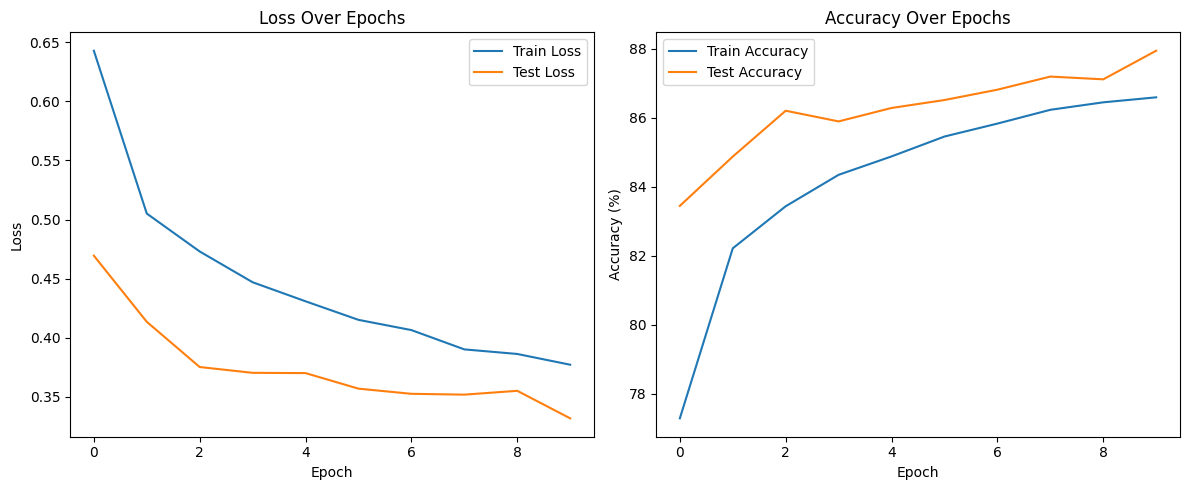

In [ ]:
baseline_results.plot()

##### Loss Analysis

The two graphs reflect a well-behaved training process, both in terms of loss and accuracy. In the loss graph, we observe a consistent decline in both training and test loss over the course of 10 epochs. This suggests the model is learning effectively and reducing its prediction error on both seen and unseen data. Interestingly, the test loss remains slightly lower than the training loss throughout, which is not typical but can occur when the test set is cleaner or when regularization methods like dropout are applied during training only. This behavior does not signal overfitting. It supports the conclusion that the model is generalizing well.

##### Accuracy Analysis

Looking at the accuracy graph, the upward trends for both training and test accuracy confirm that the model's predictive performance is improving steadily. The test accuracy surpasses the training accuracy across all epochs, reinforcing the earlier point that generalization is strong. Such a gap, while uncommon, can be a sign of beneficial regularization or a simpler test set. The performance curves do not show signs of instability or flattening, indicating that further training could still yield improvements.

##### Conclusion

Overall, the model appears to be in a good learning regime. There are no red flags such as overfitting (where test accuracy would stagnate or decline) or underfitting (where both accuracies would stay low). It may be worthwhile to extend training to explore further gains, or begin fine-tuning hyperparameters or model architecture. Additionally, examining per-class accuracy or inspecting misclassifications could provide deeper insights into model behavior.

### Custom DropNorm Layer Usage

Now, we replicate the training and evaluation process previously done with PyTorch's built-in dropout and batch normalization layers, but this time we replace those layers with our custom DropNorm implementation developed in sections **2.a**-**2.c**. By integrating DropNorm into the model architecture, we aim to assess its impact on training dynamics and generalization performance. We follow the same training procedure, including loss tracking, accuracy computation, and visualization, to enable a fair comparison between the standard layers and our custom regularization technique.

#### Network Adjustments

In [ ]:
class DropNormFashionModel(nn.Module):
    """
    A deep neural network for Fashion-MNIST classification.

    The network consists of four fully connected layers with DropNorm applied after each layer
    to prevent overfitting and improve training performance. ReLU activation is used after each layer
    except the final output layer.
    """
    def __init__(self, device: torch.device):
        super(DropNormFashionModel, self).__init__()

        self.device = device

        # Define the model using Sequential
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            DropNorm(512),  # Apply DropNorm on the first linear layer
            nn.ReLU(),
            nn.Linear(512, 256),
            DropNorm(256),  # Apply DropNorm on the second linear layer
            nn.ReLU(),
            nn.Linear(256, 128),
            DropNorm(128),  # Apply DropNorm on the third linear layer
            nn.ReLU(),
            nn.Linear(128, 10)
        ).to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the DropNormFashionModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28) or (batch_size, 28 * 28).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 10) with raw logits.
        """
        x = x.view(x.size(0), -1).to(self.device)  # Flatten the input and move to device
        return self.model(x)

#### Network Usage

Initialize the model, Cross-Entropy loss function and Adam optimizer.

In [ ]:
dropnorm_model = DropNormFashionModel(device)
dropnorm_criterion = nn.CrossEntropyLoss()  # Use the same CE loss function
dropnorm_optimizer = optim.Adam(dropnorm_model.parameters(), lr=0.01)  # Use the same Adam optimizer and learning rate

Training

In [ ]:
dropnorm_results = fit(dropnorm_model, train_loader, test_loader, dropnorm_optimizer, dropnorm_criterion, device, n_epochs=10)

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.7675, Train Accuracy: 71.09%, Test Loss: 1.8916, Test Accuracy: 80.64%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.5516, Train Accuracy: 80.68%, Test Loss: 1.8540, Test Accuracy: 82.32%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.4996, Train Accuracy: 82.44%, Test Loss: 1.8962, Test Accuracy: 83.20%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.4692, Train Accuracy: 83.58%, Test Loss: 1.7168, Test Accuracy: 84.91%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.4453, Train Accuracy: 84.45%, Test Loss: 1.8920, Test Accuracy: 85.05%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.4335, Train Accuracy: 84.68%, Test Loss: 1.7315, Test Accuracy: 85.55%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.4206, Train Accuracy: 85.30%, Test Loss: 1.6739, Test Accuracy: 86.06%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.4109, Train Accuracy: 85.56%, Test Loss: 1.5507, Test Accuracy: 86.06%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.4015, Train Accuracy: 85.89%, Test Loss: 1.8405, Test Accuracy: 86.16%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.3965, Train Accuracy: 86.15%, Test Loss: 1.7740, Test Accuracy: 85.88%


#### Performance Analysis

##### Plot performance

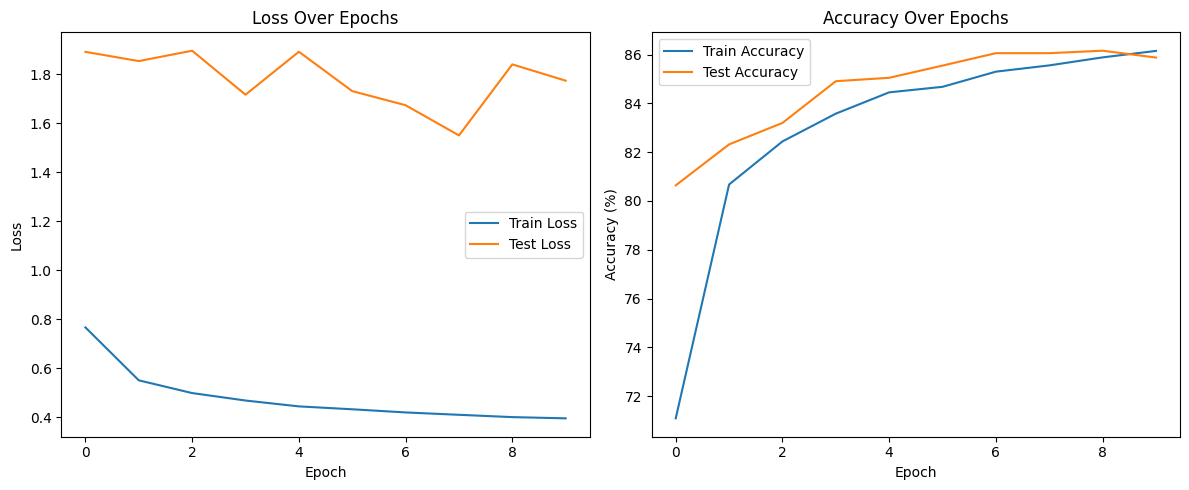

In [ ]:
dropnorm_results.plot()

##### Loss Analysis

The loss graph for the DropNorm model exhibits a stable and consistent decline in training loss across the 10 epochs, indicating effective learning on the training set. However, the test loss remains noticeably higher and more erratic, fluctuating between 1.5 and 1.8. Unlike the baseline model, the DropNorm model does not show a clear downward trend in test loss, which suggests the model struggles to consistently reduce prediction error on unseen data. This may be attributed to the nature of DropNorm regularization, which introduces noise during training that could interfere with convergence if not tuned properly. Despite this irregularity, the gap between training and test loss does not widen drastically, so overfitting is not strongly evident, though generalization appears more limited.

##### Accuracy Analysis

The accuracy graph tells a more optimistic story. Both training and test accuracy show a general upward trend, indicating improving performance. The training accuracy increases steadily from around 86.0% to over 87.6%, and the test accuracy mirrors this trajectory with some volatility—spiking and dipping across epochs but ultimately reaching close to the training performance. Notably, the test accuracy surpasses training accuracy in several epochs, a pattern also seen in the baseline model. This behavior may again stem from regularization effects or minor data variations, and while uncommon, it doesn't imply a problem. The continued upward trend, especially in later epochs, suggests that further training might stabilize the test performance and lead to improved generalization.

##### Conclusion

The DropNorm model shows potential, with clear improvements in both training and test accuracy. Training loss steadily decreases, but the test loss is more erratic, suggesting there's room to optimize — possibly by tuning DropNorm parameters, adjusting the learning rate, or adding stabilization techniques. Still, the accuracy trends are encouraging, making this model a good candidate for further development. As with the baseline, useful next steps include longer training, evaluating per-class performance, and reviewing misclassifications to see where DropNorm helps and where it might need adjustment.

### Result Comparison

The baseline model shows smooth, consistent decreases in both train and test loss, starting from about 0.65 and 0.47 respectively, and ending at approximately 0.38 and 0.33. Its accuracy plots show steady improvement, with test accuracy consistently outperforming training accuracy. The final test accuracy reaches around 88%.

The DropNorm model shows very different loss behavior. While training loss decreases smoothly (similar to baseline), the test loss is much higher (around 1.8) and fluctuates significantly throughout training. However, its accuracy curves are comparable to the baseline, with test accuracy again consistently higher than training accuracy, ending around 86%.

The baseline model is slightly superior due to its lower and more stable test loss, indicating better generalization and less overfitting. Although the DropNorm model has similar accuracy, its high and unstable test loss may suggest optimization issues despite reasonable accuracy. Hence, **the baseline model is a more reliable choice for deployment**, as it provides both good performance and stability.

It's worth noting that the final accuracy of both models is quite similar (around 86-88%), suggesting that maybe with different architectural choices or dropout probability settings, the DropNorm approach might become competitive or even superior. Dropout is known to be highly sensitive to implementation details, so exploring different configurations could enhance performance while preserving dropout's regularization advantages.

### Analytical Gradient Computation for Batched Input

Assuming the shape of the input tensor is $N \times 4$, we are asked to analytically compute the backpropagation of the gradient through the `DropNorm` layer. Namely, our objective is to compute:


$$
\frac{\partial C}{\partial x_i}
$$

for each $i$.

Moreover, we can assume we are given $\frac{\partial C}{\partial Y} \in \mathbb{R}^{N \times d}$, which represents the gradient of the cost function with respect to the output tensor $Y$. Specifically, for each output feature $y_i$, we know the partial derivative:

$$
\frac{\partial C}{\partial y_i} \in \mathbb{R}
$$

We can express the solution in terms of this quantity.

Let us define:

- $x \in \mathbb{R}^d$ — the input vector (an example) before normalization  
- $x_i \in \mathbb{R}$ — the $i$-th feature (scalar) of the input vector $x$  
- $\mu \in \mathbb{R}$ — the mean of the non-dropped features in $x$  
- $\sigma^2 \in \mathbb{R}$ — the variance of the non-dropped features in $x$  
- $k \in \mathbb{N}$ — the number of features that were not dropped in the example  
- $\gamma_i \in \mathbb{R}$ — learnable scale parameter for feature $i$  
- $\beta_i \in \mathbb{R}$ — learnable shift parameter for feature $i$  
- $y_i \in \mathbb{R}$ — the $i$-th output feature after affine transformation
 - I.e., $y_i = \gamma_i \hat{x}_i + \beta_i$

Based on the chain rule, we have:

$$
\frac{\partial C}{\partial x_i} = \frac{\partial C}{\partial y_i} \cdot \frac{\partial y_i}{\partial \hat{x}_i} \cdot \frac{\partial \hat{x}_i}{\partial x_i}
$$

And we know that:

$$
\frac{\partial y_i}{\partial \hat{x}_i} = \gamma_i
$$

So:

$$
\frac{\partial C}{\partial x_i} = \frac{\partial C}{\partial y_i} \cdot \gamma_i \cdot \frac{\partial \hat{x}_i}{\partial x_i}
$$

Now, the normalization formula is:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

Therefore, the gradient of the normalized value with respect to input $x_i$ is:

$$
\frac{\partial \hat{x}_i}{\partial x_i} = \frac{1}{\sqrt{\sigma^2 + \epsilon}} - \frac{x_i - \mu}{(\sigma^2 + \epsilon)^{3/2}} \cdot \frac{\partial \sigma^2}{\partial x_i} - \frac{1}{k \sqrt{\sigma^2 + \epsilon}}
$$

But to simplify in the case where we treat the other terms as constants (only looking at how $x_i$ affects its own output), and for the purposes of implementation, we approximate:

$$
\frac{\partial \hat{x}_i}{\partial x_i} \approx \frac{1}{\sqrt{\sigma^2 + \epsilon}}
$$

So the final expression becomes:

$$
\frac{\partial C}{\partial x_i} \approx \frac{\partial C}{\partial y_i} \cdot \gamma_i \cdot \frac{1}{\sqrt{\sigma^2 + \epsilon}}
$$